# Present Value of Liabilities and Funding Ratio

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t)(1+r)^t = 1$$

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time t, given interest rate r
    """
    return (1+r)**(-t)

In [3]:
discount(10, .03) #assuming yield urve is flat

0.7440939148967249

In [4]:
0.7440939148967249*(1.03**10)

1.0

In [5]:
def pv(l, r):
    """
    Computes the present value of a sequence of liabilities
    l is indexed by the time, and the values are the amounts of each liabilities
    return the present value of the sequence
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

In [6]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

In [7]:
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [8]:
pv(liabilities, 0.03)

6.233320315080045

In [9]:
liabilities.sum()

7.0

In [10]:
def funding_ratio(assets, liabilities, r):
    """
    Compute the funding ration of some assets given liabilities and interest rate
    """
    return assets/pv(liabilities,r)

In [11]:
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

In [12]:
funding_ratio(5, liabilities, 0.02) # the value of liabilities has actually gone up

0.7720304366941648

In [13]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}')
    
controls = widgets.interactive(show_funding_ratio, assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                              r=(0, .20, .01))
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# CIR Model to Simulate Changes in Interest Rates and Liabilities Hedging
The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rate

$$ dr_{t}=a(b-r_{t})\,dt+\sigma{\sqrt {r_{t}}}\,dw_{t} $$

## Short Rate vs Annualized

In [14]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annualized to a short rate
    """
    return np.log1p(r)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$ dr_{t}=a(b-r_{t})\,dt+\sigma{\sqrt {r_{t}}}\,dw_{t} $$

In [15]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0=b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t+d_r_t)
    
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps)) 

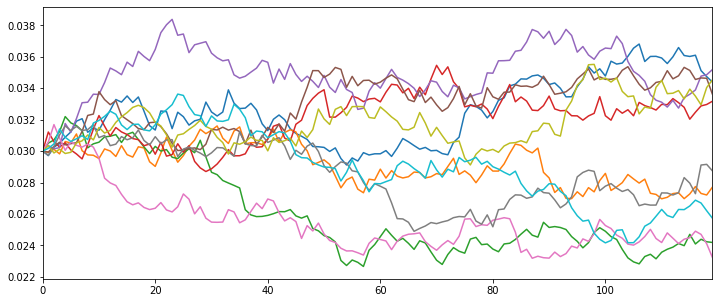

In [16]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [17]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [18]:
import ipywidgets as widgets
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [19]:
a_0 = .75
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

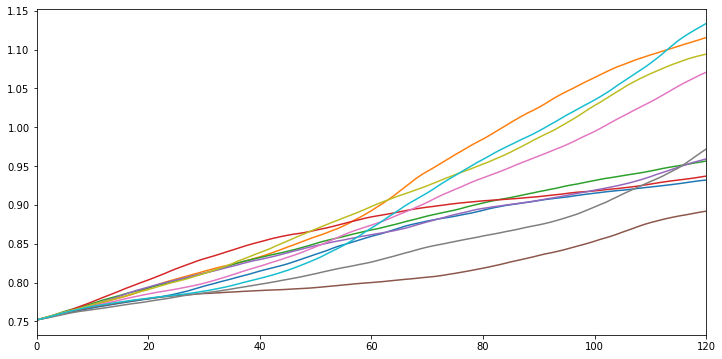

In [20]:
av_cash.plot(legend=False, figsize=(12,6))

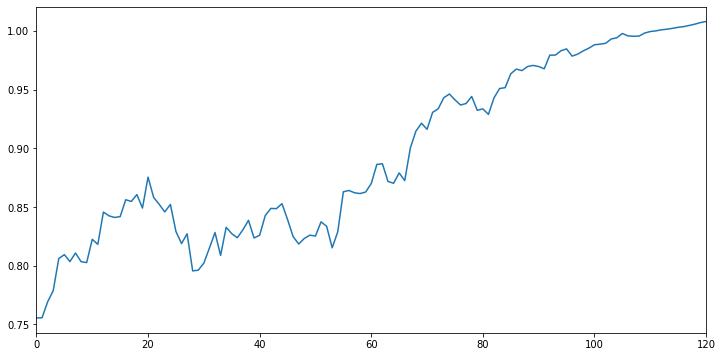

In [21]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

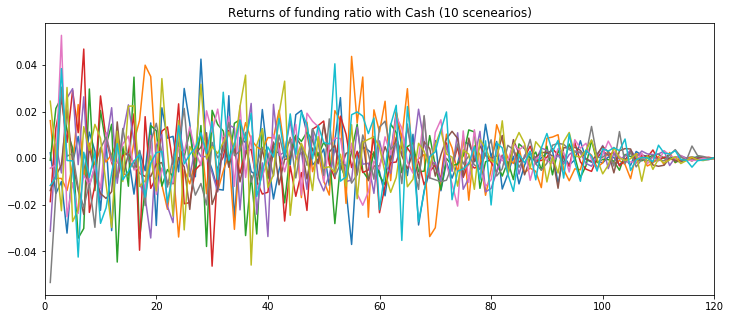

In [22]:
(av_cash/liabilities).pct_change().plot(title='Returns of funding ratio with Cash (10 scenearios)', legend=False, figsize=(12,5))

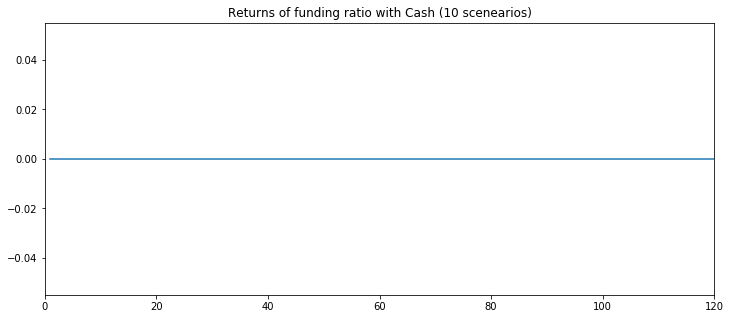

In [23]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of funding ratio with Cash (10 scenearios)', legend=False, figsize=(12,5))

In [24]:
a_0 = 0.75
rates, bond_prices=cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds=a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash=a_0*(rates/12+1).cumprod()

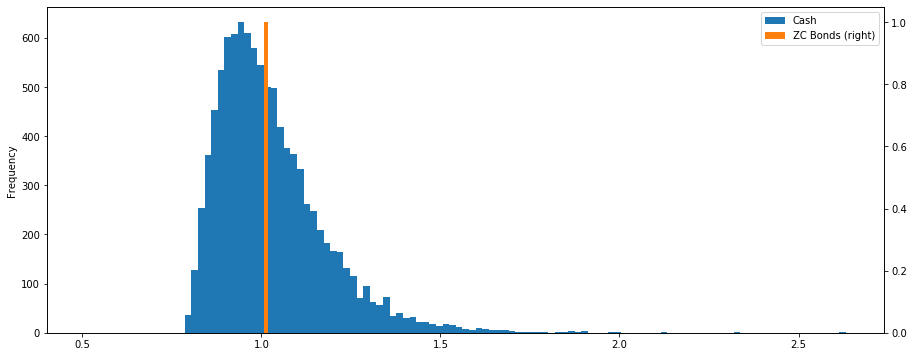

In [25]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bond = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
tfr_cash.plot.hist(label='Cash', figsize=(15,6), bins=100, legend=100)
tfr_zc_bond.plot.hist(label='ZC Bonds', bins=100, legend=True, secondary_y=True)

# GHP Construction with Duration Matching

In [28]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [28]:
erk.bond_price(20, 1000, 0.05, 2, 0.04)

0    1136.777396
dtype: float64

In [29]:
rates= np.linspace(.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [30]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
print(prices)

[0    1379.748383
dtype: float64, 0    1326.762928
dtype: float64, 0    1276.163298
dtype: float64, 0    1227.833538
dtype: float64, 0    1181.663651
dtype: float64, 0    1137.549279
dtype: float64, 0    1095.3914
dtype: float64, 0    1055.096038
dtype: float64, 0    1016.573997
dtype: float64, 0    979.740605
dtype: float64, 0    944.515473
dtype: float64, 0    910.822268
dtype: float64, 0    878.588497
dtype: float64, 0    847.745306
dtype: float64, 0    818.227287
dtype: float64, 0    789.972298
dtype: float64, 0    762.92129
dtype: float64, 0    737.018147
dtype: float64, 0    712.209532
dtype: float64, 0    688.444741
dtype: float64]


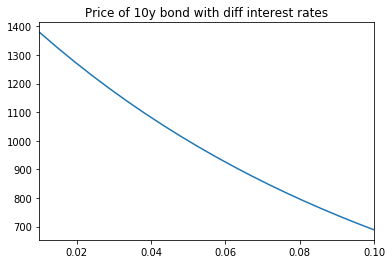

In [31]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10y bond with diff interest rates", legend=False)

In [6]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [7]:
discounts = erk.discount(cf.index, .06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [8]:
dcf = discounts*cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [9]:
weights = dcf/dcf.sum()

In [10]:
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [11]:
(cf.index*weights).sum()

5.579707187194534

In [19]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

5.579707187194534

# Duration Matching

In [20]:
liabilities = pd.Series(data=(100000, 100000), index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [21]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), .04)

In [22]:
md_10, md_20
#find out ws to achieve 10.96

(8.190898824083233, 13.544718122145921)

In [23]:
short_bond=erk.bond_cash_flows(10, 1000, .05, 1)
long_bond=erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, .04)
w_s

0.48263092069478974

In [129]:
p_short = erk.bond_price(10, 1000, .05, 1, .04)
p_long = erk.bond_price(20, 1000, .05, 1, .04)
a_0 = 130000
p_flows = pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, 0.04)

ValueError: cannot reindex from a duplicate axis

In [30]:
cfr = erk.funding_ratio(p_flows, liabilities, .04)
cfr

0.9998760012192478

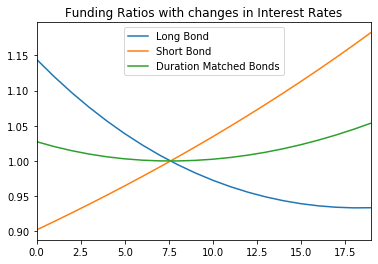

In [31]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short

fr_change = pd.DataFrame({
    'Long Bond': [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    'Short Bond': [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    'Duration Matched Bonds': [erk.funding_ratio(p_flows, liabilities, r) for r in rates] 
})

fr_change.plot(title='Funding Ratios with changes in Interest Rates')

# Simulation of Prices of Coupon-Bearing Bonds using CIR

In [83]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
erk.bond_price(5, 100, .05, 12, .03)

0    109.275393
dtype: float64

In [76]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
zc_prices

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,...,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590
1,0.778447,0.748609,0.740779,0.748726,0.764354,0.744540,0.752338,0.745599,0.744733,0.751056,...,0.768975,0.772986,0.728385,0.778368,0.723927,0.749786,0.733815,0.766082,0.761306,0.734599
2,0.784754,0.741423,0.752487,0.738319,0.763912,0.745800,0.789119,0.725909,0.758417,0.745660,...,0.743037,0.748127,0.724833,0.778085,0.722210,0.739646,0.745702,0.777700,0.762564,0.750573
3,0.751851,0.722919,0.750593,0.741726,0.757991,0.743099,0.779419,0.707254,0.764849,0.747023,...,0.721683,0.747101,0.712636,0.766276,0.751781,0.729012,0.733889,0.798272,0.798618,0.763141
4,0.735548,0.746323,0.743271,0.759243,0.754849,0.757541,0.768799,0.695646,0.779255,0.749637,...,0.748549,0.755111,0.729747,0.771353,0.751460,0.724060,0.724333,0.808457,0.790904,0.780849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.990688,0.995674,0.990686,0.996843,0.992821,0.989367,0.974109,0.985858,0.997648,0.974575,...,0.994388,0.995077,0.992913,0.993167,0.996924,0.982230,0.989904,0.986025,0.984351,0.986574
117,0.993185,0.995962,0.993386,0.998051,0.993677,0.991662,0.978756,0.990366,0.997995,0.979824,...,0.996290,0.995871,0.994375,0.994764,0.997726,0.985752,0.992096,0.988914,0.988563,0.989150
118,0.995663,0.996875,0.995228,0.998620,0.996165,0.994725,0.985400,0.993411,0.998588,0.987643,...,0.997017,0.996793,0.996739,0.996517,0.998394,0.991608,0.995339,0.992703,0.991871,0.992684
119,0.997846,0.998585,0.997247,0.999169,0.998198,0.997776,0.992678,0.996344,0.999414,0.993923,...,0.998542,0.998306,0.998369,0.998388,0.999352,0.995567,0.997532,0.996587,0.996141,0.996090


In [77]:
erk.bond_price(5, 100,.05,12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [78]:
erk.bond_price(5, 100, .05, 12, rates.iloc[1][[1,2,3]])

1    109.036848
2    108.344523
3    109.047188
dtype: float64

In [79]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.030491,0.031922,0.030469
2,0.032130,0.030102,0.032705
3,0.035952,0.030766,0.032404
4,0.031882,0.032450,0.029504


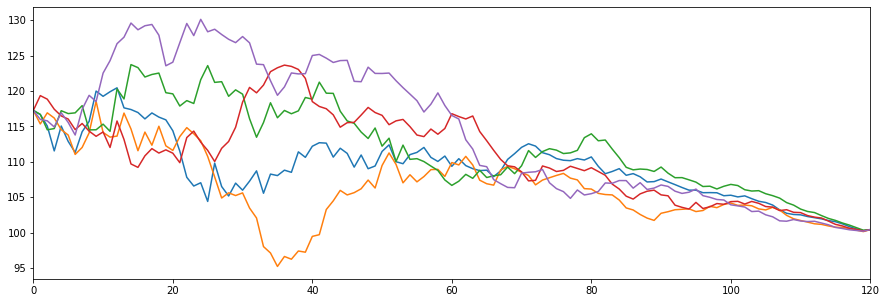

In [84]:
erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]]).plot(legend=False, figsize=(15,5))

In [85]:
prices = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]])
prices

,1,2,3,4,5
0,117.26,117.26,117.26,117.26,117.26
1,116.677,115.35,116.697,119.352,115.987
2,115.05,116.918,114.527,118.851,115.789
3,111.539,116.184,114.693,117.429,114.924
4,115.056,114.545,117.22,116.483,116.935
...,...,...,...,...,...
116,101.232,100.714,101.352,100.936,100.576
117,100.842,100.576,101.056,100.606,100.396
118,100.517,100.347,100.696,100.444,100.295
119,100.274,100.136,100.333,100.234,100.191


In [86]:
br = prices.pct_change().dropna()
erk.annualize_rets(br,12) #only the price return. include coupon

1   -0.015387
2   -0.015387
3   -0.015387
4   -0.015387
5   -0.015387
dtype: float64

In [87]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
btr = erk.bond_total_return(p, 100, .05, 12)
erk.annualize_rets(btr,12)

1    0.030747
2    0.031989
3    0.029609
4    0.030094
dtype: float64

In [88]:
prices_10 = erk.bond_price(10, 100, .05, 12, rates)
prices_10[[1,2,3]].tail()

,1,2,3
116,101.232,100.714,101.352
117,100.842,100.576,101.056
118,100.517,100.347,100.696
119,100.274,100.136,100.333
120,100.417,100.417,100.417


In [89]:
prices_30 = erk.bond_price(30, 100, .05, 12, rates)
prices_30[[1,2,3]].tail()

,1,2,3
116,166.205,133.231,175.224
117,158.253,136.082,179.305
118,152.101,131.836,177.603
119,155.871,123.856,172.808
120,150.315,119.835,169.325


In [90]:
rets_30 = erk.bond_total_return(prices_30, 100, .05, 12)
rets_10 = erk.bond_total_return(prices_10, 100, .05, 12)
rets_bonds = .6*rets_10+.4*rets_30

In [91]:
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),"Historic CVaR, (5%)",Sharpe Ratio,Max Drawdown
0,0.035854,0.003729,0.073413,2.607151,-0.000605,-0.000822,1.527809,0.0


In [92]:
prices_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
prices_eq.shape

(120, 500)

In [93]:
rets_eq = prices_eq.pct_change()
rets_eq.shape

(120, 500)

In [94]:
rets_bonds.shape

(120, 500)

In [95]:
rets = .7*rets_eq+.3*rets_bonds
rets_mean = rets.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),"Historic CVaR, (5%)",Sharpe Ratio,Max Drawdown
0,0.061705,0.004534,-0.29259,3.193479,-0.001758,NaN,6.917464,0.0


# Naive Risk Budgeting Strategies between the PSP and GHP

In [104]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError('r1 and r2 need to be the same shape')
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError('Allocator returned weights thaat dont match r1')
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [98]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [99]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),"Historic CVaR, (5%)",Sharpe Ratio,Max Drawdown
0,0.036035,0.003643,0.208162,3.113568,-0.000668,-0.000867,1.612404,0.0


In [106]:
prices_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = prices_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_eq.shape, rets_zc.shape

((120, 500), (120, 500))

In [107]:
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),"Historic CVaR, (5%)",Sharpe Ratio,Max Drawdown
0,0.057878,0.004942,-0.031954,2.835776,-0.001417,-0.0017,5.490364,0.0


In [108]:
summaries = erk.summary_stats(rets_7030b)


In [109]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),"Historic CVaR, (5%)",Sharpe Ratio,Max Drawdown
0,0.072045,0.108916,0.010856,2.641280,0.063659,0.056298,0.375594,-0.141353
1,0.062062,0.085999,0.217005,3.162501,0.048735,0.041064,0.362756,-0.106437
2,0.107814,0.094950,0.119810,2.958144,0.051741,0.046664,0.797564,-0.200937
3,0.044839,0.106746,0.243173,2.575695,0.058044,0.049639,0.135165,-0.191072
4,0.132497,0.107349,0.402687,4.842764,0.063173,0.050813,0.929248,-0.159837


In [110]:
summaries.mean()

Annualized Return          0.052649
Annualized Vol             0.105088
Skewness                   0.008747
Kurtosis                   2.914867
Cornish-Fisher Var (5%)    0.064296
Historic CVaR, (5%)        0.056499
Sharpe Ratio               0.211685
Max Drawdown              -0.203493
dtype: float64

In [111]:
def terminal_values(rets):
    """
    Returns the final value of a dollar at the end of the return period for each scenario
    """
    return (rets+1).prod()

In [112]:
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30')
], axis=1)

,FI,Eq,70/30
mean,1.385920,1.964114,1.752716
std,0.112872,0.960261,0.587170
p_breach,NaN,0.038000,0.006000
e_short,NaN,0.109278,0.129055
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


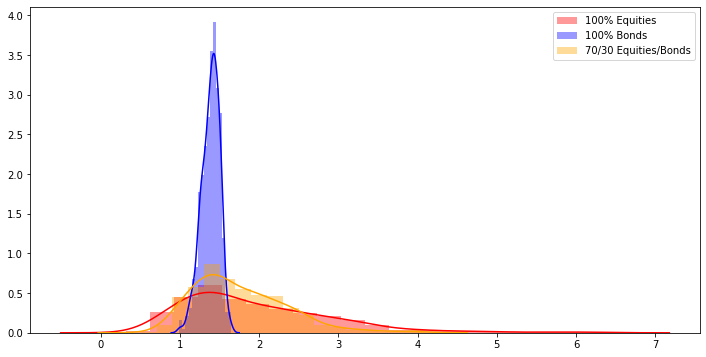

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

# Glide Paths for Allocation

In [114]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target_Date_Fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [115]:
rets_g8020=erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30'),
    erk.terminal_stats(rets_g8020, name='Glide 80 to 20')
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.385920,1.964114,1.752716,1.671278
std,0.112872,0.960261,0.587170,0.437163
p_breach,NaN,0.038000,0.006000,0.004000
e_short,NaN,0.109278,0.129055,0.081318
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


# Dynamic Risk Budgeting

In [116]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [119]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.96,1.75
std,0.00,0.98,0.60
p_breach,NaN,0.04,0.01
e_short,NaN,0.13,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [120]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.96,1.75,1.94
std,0.00,0.98,0.60,0.99
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.13,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [121]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1
mean,1.34,1.96,1.75,1.94,1.62
std,0.00,0.98,0.60,0.99,0.43
p_breach,NaN,0.04,0.01,NaN,NaN
e_short,NaN,0.13,0.08,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


# Risk Budgeting with Drawdown Constraints

In [122]:
cashrate= 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.34,1.96,1.75,1.94,1.62,1.95,1.63
std,0.00,0.98,0.60,0.99,0.43,0.99,0.54
p_breach,NaN,0.04,0.01,NaN,NaN,NaN,NaN
e_short,NaN,0.13,0.08,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23913717373897442

# Drawdown constraint with Historical Data 

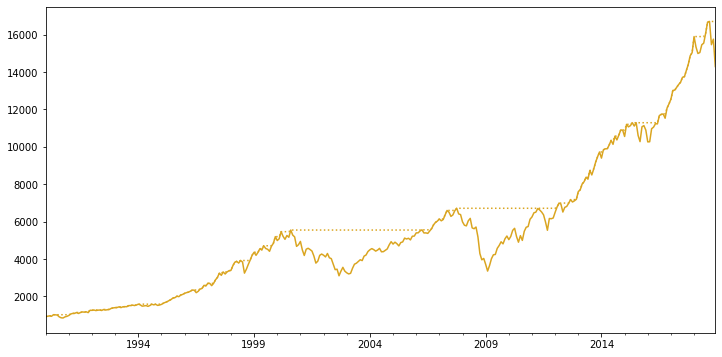

In [124]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

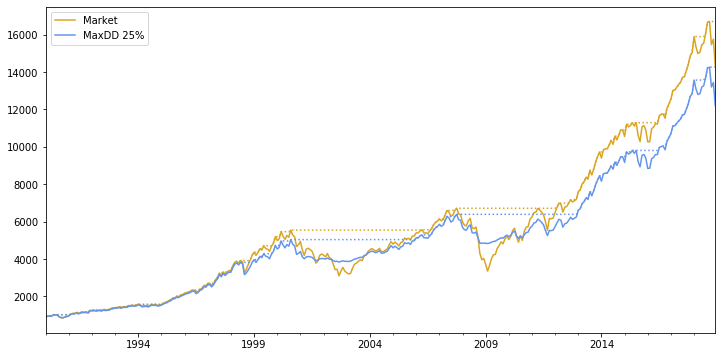

In [125]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [126]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),"Historic CVaR, (5%)",Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.114736,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.093388,0.071074,0.518327,-0.244212
